The second part of task 3 consists of the development of a deep learning model to predict the taxi trip demand in spatio-temporal resolution.

In [37]:
##### Imports #####

import pandas as pd
import numpy as np
import h3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, max_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [15]:
##### Load Data #####

chicago = pd.read_csv("Chicago_Trips_Weather_2024.csv")

In [16]:
##### Data Overview ######
print(chicago.info())
chicago.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888777 entries, 0 to 4888776
Data columns (total 35 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip Start Timestamp        object 
 1   Trip End Timestamp          object 
 2   Trip Seconds                float64
 3   Trip Miles                  float64
 4   Fare                        float64
 5   Tips                        float64
 6   Tolls                       float64
 7   Extras                      float64
 8   Trip Total                  float64
 9   Pickup Centroid Latitude    float64
 10  Pickup Centroid Longitude   float64
 11  Dropoff Centroid Latitude   float64
 12  Dropoff Centroid Longitude  float64
 13  pickup_h3                   object 
 14  dropoff_h3                  object 
 15  trip_start_time_bucket      object 
 16  hourly_trip_count           int64  
 17  start_day                   int64  
 18  start_hour                  int64  
 19  isWeekday            

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Fare,Tips,Tolls,Extras,Trip Total,Pickup Centroid Latitude,...,timestamp_utc,temp,app_temp,rh,wind_spd,wind_gust_spd,precip,snow,ghi,vis
0,2024-01-19 17:00:00+00:00,2024-01-19 18:00:00,4051.0,17.12,45.50,10.00,0.0,4.0,60.00,41.979071,...,2024-01-19 17:00:00+00:00,-10.7,-19.5,68.0,6.70,12.8,0.0,0.0,426.0,10.0
1,2024-01-05 09:00:00+00:00,2024-01-05 09:00:00,517.0,3.39,10.91,2.78,0.0,1.0,14.69,41.944227,...,2024-01-05 09:00:00+00:00,-0.9,-4.2,69.0,2.60,3.5,0.0,0.0,0.0,16.0
2,2024-01-18 19:15:00+00:00,2024-01-18 19:30:00,1004.0,1.18,15.94,3.72,0.0,0.0,19.66,41.880994,...,2024-01-18 19:00:00+00:00,-4.6,-9.6,65.0,3.60,3.6,0.0,0.0,424.0,16.0
3,2024-01-04 07:15:00+00:00,2024-01-04 07:30:00,484.0,1.59,7.75,1.24,0.0,0.0,9.49,41.879255,...,2024-01-04 07:00:00+00:00,1.4,-2.6,71.0,4.09,7.5,0.0,0.0,0.0,16.0
4,2024-01-25 11:15:00+00:00,2024-01-25 11:30:00,1686.0,13.01,34.25,7.95,0.0,5.0,47.70,41.884987,...,2024-01-25 11:00:00+00:00,1.8,-1.8,96.0,3.60,4.6,0.0,0.0,0.0,10.0


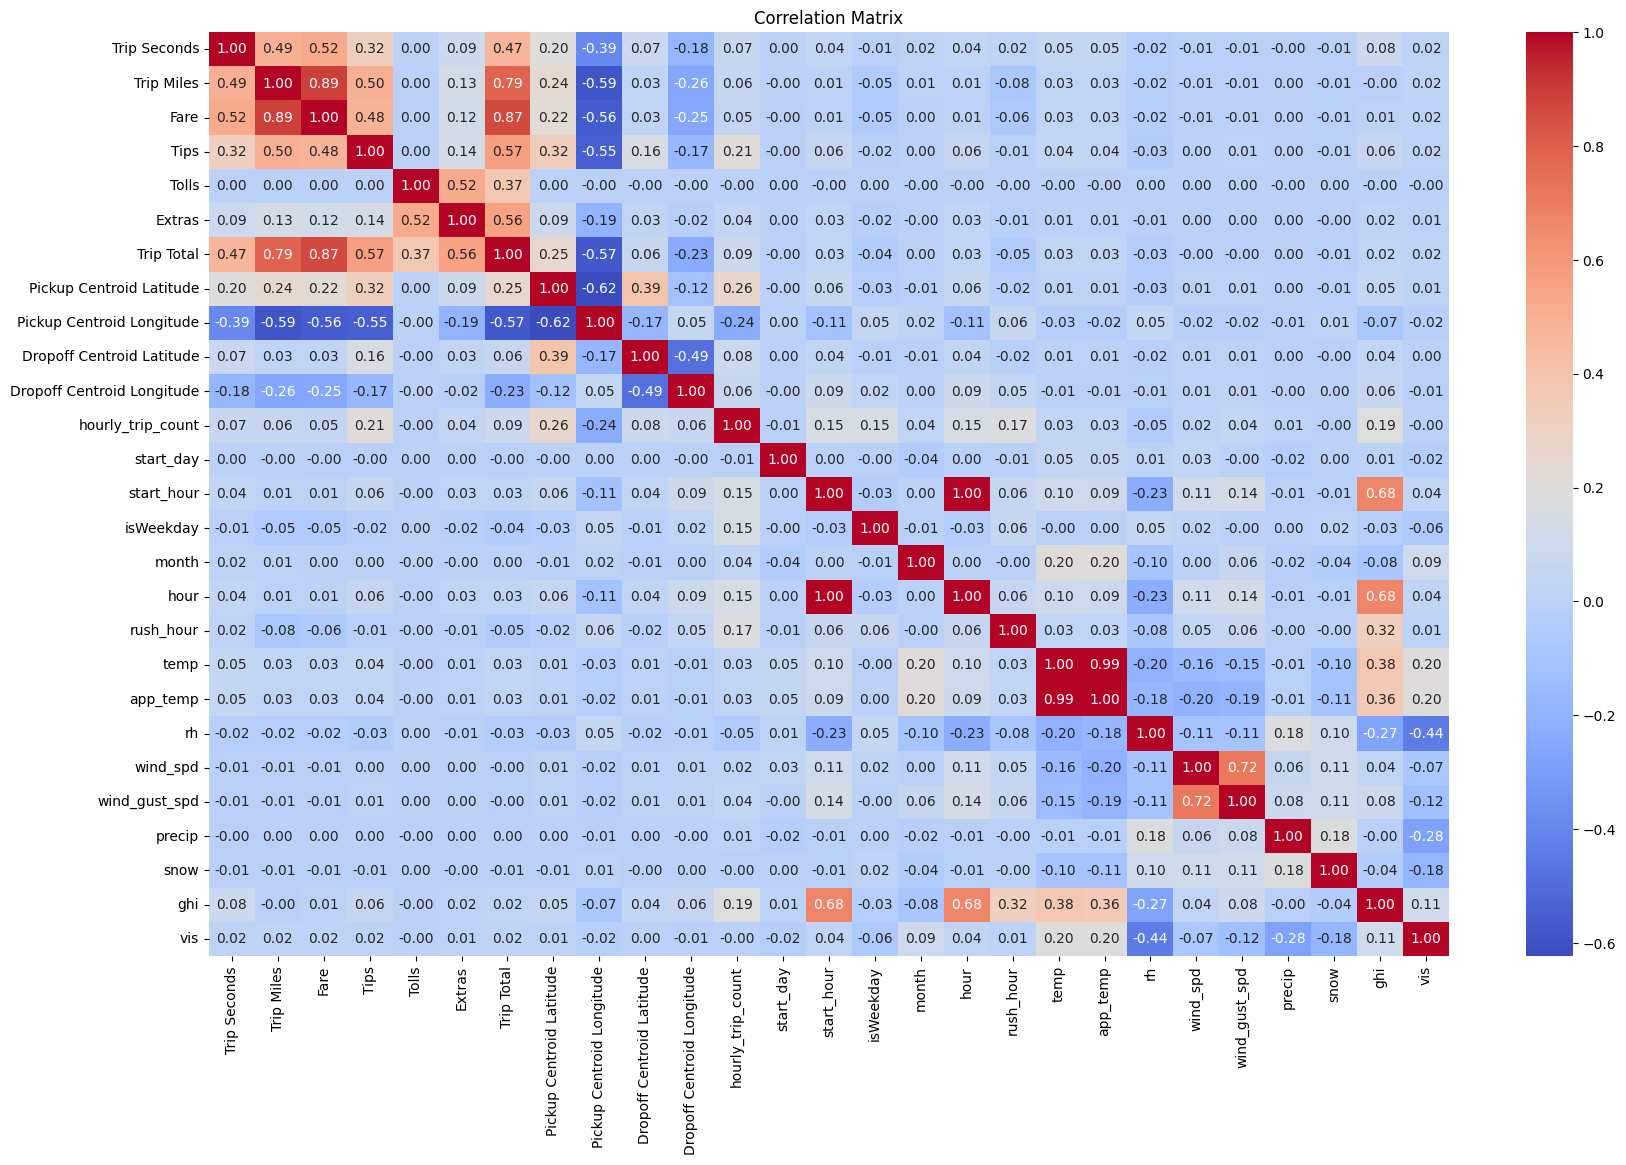

In [18]:
# correlation matrix
numeric_columns = chicago.select_dtypes(include='number')

corr_matrix = numeric_columns.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


We can see that the temperature (temp) and the felt temperature (app_temp) are highly correlated, very close to 1 so we should keep only one of them. We decided to keep the actual temperature instead of the felt temperature.

Also the Trip Total and all other more detailed cost information (fare, tips, tolls, extras) are highly corelated. Therefore we decided to drop the detailed information and keep the trip total to further simplify our data structure for the prediction models.

In [19]:
chicago.drop(columns=["app_temp", "Fare", "Tips", "Tolls", "Extras"], inplace=True)

In [20]:
chicago.columns

Index(['Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds',
       'Trip Miles', 'Trip Total', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Dropoff Centroid Latitude',
       'Dropoff Centroid Longitude', 'pickup_h3', 'dropoff_h3',
       'trip_start_time_bucket', 'hourly_trip_count', 'start_day',
       'start_hour', 'isWeekday', 'month', 'hour', 'rush_hour', 'season',
       'Trip Start Hour', 'timestamp_utc', 'temp', 'rh', 'wind_spd',
       'wind_gust_spd', 'precip', 'snow', 'ghi', 'vis'],
      dtype='object')

In [ ]:
# Evaluation metrics
def evaluate_performance(y_test,pred_ann,df):
    print("MODEL SCORES")
    print("MAE:", round(mean_absolute_error(y_test,pred_ann), 4))
    print("RMSE:", round(mean_squared_error(y_test,pred_ann)**0.5, 4))
    print("R2:", round(r2_score(y_test,pred_ann), 4))
    print("MAPE:", round(mean_absolute_percentage_error(y_test,pred_ann)*100, 2), "%")

In [ ]:
# before we can just put in all our data into our models, we need to preprocess them a little:

# we need to scale the location data
le = LabelEncoder()
chicago['pickup_h3_encoded'] = le.fit_transform(chicago['pickup_h3'])

n_zones = chicago['pickup_h3_encoded'].nunique()

zone_input = Input(shape=(1,), name='zone')
zone_emb = Embedding(input_dim=n_zones, output_dim=8)(zone_input)
zone_vec = Flatten()(zone_emb)

# Example with other inputs
other_input = Input(shape=(n_numeric_features,), name='features')
x = Concatenate()([zone_vec, other_input])
x = Dense(64, activation='relu')(x)
x = Dense(1)(x)

model = Model(inputs=[zone_input, other_input], outputs=x)




In [ ]:
##### Step 1: Feature Selection & Encoding #####

# Automatically select numeric features
numeric_cols = chicago.select_dtypes(include=['number']).columns.tolist()

# Exclude target and encoded categorical variables (if needed)
exclude = ['pickup_h3_encoded', 'hourly_trip_count']  # adjust as needed
X_features = [col for col in numeric_cols if col not in exclude]

# Define features and target
X = chicago[X_features]
y = chicago['hourly_trip_count']

In [42]:
##### Step 2: Normalize + Train/Test/Validation Split #####

# Normalize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split: 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# From training, take 20% for validation → 50/20/30 split overall
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(0.2 / 0.7), random_state=42)


In [43]:
##### Step 3: Build and Train the Model #####

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stop])

Epoch 1/50
76388/76388 [==============================] - 56s 725us/step - loss: 0.4243 - mae: 0.4671 - val_loss: 0.3600 - val_mae: 0.4367
Epoch 2/50
76388/76388 [==============================] - 56s 727us/step - loss: 0.3462 - mae: 0.4147 - val_loss: 0.3484 - val_mae: 0.4170
Epoch 3/50
76388/76388 [==============================] - 55s 724us/step - loss: 0.3116 - mae: 0.3992 - val_loss: 0.3000 - val_mae: 0.3906
Epoch 4/50
76388/76388 [==============================] - 55s 723us/step - loss: 0.3076 - mae: 0.3954 - val_loss: 0.2964 - val_mae: 0.4017
Epoch 5/50
76388/76388 [==============================] - 55s 719us/step - loss: 0.2922 - mae: 0.3912 - val_loss: 0.2776 - val_mae: 0.3830
Epoch 6/50
76388/76388 [==============================] - 55s 725us/step - loss: 0.2851 - mae: 0.3853 - val_loss: 0.2699 - val_mae: 0.3815
Epoch 7/50
76388/76388 [==============================] - 55s 718us/step - loss: 0.2850 - mae: 0.3802 - val_loss: 0.2747 - val_mae: 0.3787
Epoch 8/50
76388/76388 [===

In [ ]:
##### Step 4: Evaluation #####

y_pred = model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

In [33]:
##### Feature Engineering & Train-Test Split #####
X = chicago[['Trip Seconds',
       'Trip Miles', 'Trip Total', 'start_day',
       'start_hour', 'isWeekday', 'month', 'hour', 'rush_hour', 'season_encoded', 'temp', 'rh', 'wind_spd',
       'wind_gust_spd', 'precip', 'snow', 'ghi', 'vis']]
y = chicago['hourly_trip_count']

In [35]:
# Normalize the data
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Split the data set in 70% training set and 30% testing set
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(0.2/0.7), random_state = 42)

We decided to start with the most simple architecture of a neural network: one hidden layer

In [36]:
##### Step 4: Build and Train Model #####
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1)  # Output: predicted trip count
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, callbacks=[early_stop])

##### Step 5: Evaluation #####
y_pred = model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")



Epoch 1/50
68749/68749 [==============================] - 42s 600us/step - loss: 2492.0505 - mae: 37.6334 - val_loss: 2344.3884 - val_mae: 36.8717
Epoch 2/50
68749/68749 [==============================] - 42s 607us/step - loss: 2282.3003 - mae: 36.7174 - val_loss: 2216.7534 - val_mae: 36.6189
Epoch 3/50
68749/68749 [==============================] - 41s 603us/step - loss: 2212.1409 - mae: 36.2320 - val_loss: 2185.4128 - val_mae: 36.0825
Epoch 4/50
68749/68749 [==============================] - 42s 609us/step - loss: 2193.6138 - mae: 36.0093 - val_loss: 2163.4739 - val_mae: 35.9317
Epoch 5/50
68749/68749 [==============================] - 42s 605us/step - loss: 2185.3010 - mae: 35.8666 - val_loss: 2153.3667 - val_mae: 35.7630
Epoch 6/50
68749/68749 [==============================] - 41s 601us/step - loss: 2172.4714 - mae: 35.7669 - val_loss: 2147.2578 - val_mae: 35.6550
Epoch 7/50
68749/68749 [==============================] - 41s 594us/step - loss: 2161.9451 - mae: 35.7049 - val_loss: 

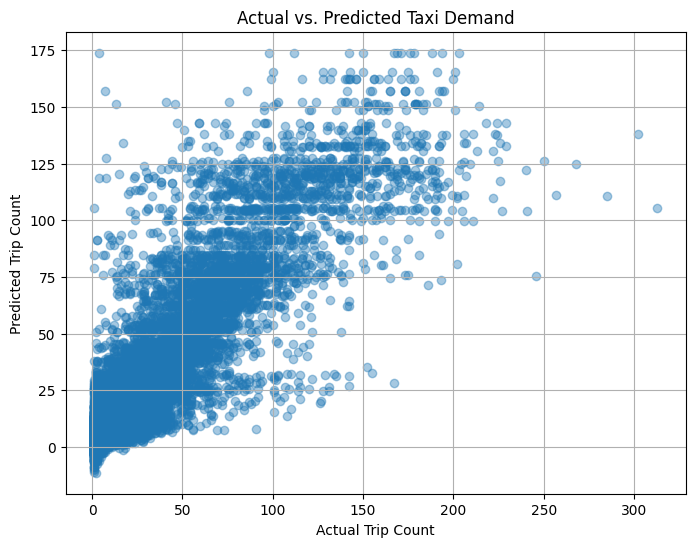

In [ ]:
##### Evaluation Visualization #####

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Trip Count")
plt.ylabel("Predicted Trip Count")
plt.title("Actual vs. Predicted Taxi Demand")
plt.grid(True)
plt.show()